To start, you will want to easily read an image. Just note that there are many options to do this -- Scikit image, OpenCV, PIL. I find it convenient to use a wrapper function (returning a Numpy array) that is easy to use and converts into a format that I can remember.

This is a function I often use:

In [13]:
import cv2


def read_image(path, as_float=True):
    
    # CV2 reads in BGR by default, ::-1 will reverse the channel dimensions to RGB.
    image = cv2.imread(path)[..., ::-1]
    
    if as_float:
        # Typically easier to work with when range is [0.0, 1.0]
        return image / 255.0
    
    return image

Read some test image and display it with matplotlib! Note that the plot also shows the x and y coordinates of the image, with top-left being (0, 0).

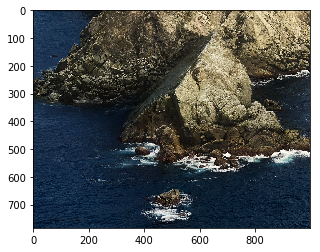

('Image shape', (784, 998, 3))


In [14]:
image = read_image('test.png')

# This following line is only required for Jupyter notebook to display matplotlib things.
%matplotlib inline

from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()
print('Image shape', image.shape)

# Basic Manipulations

Let's display a darker image!

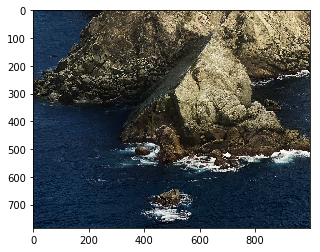

In [ ]:
dark_image = image
plt.imshow(dark_image)
plt.show()

Let's shift it right by 100 pixels!

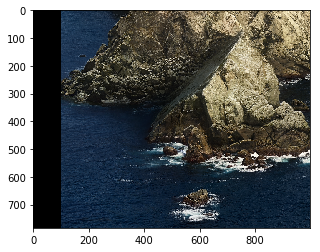

In [15]:
import numpy as np
shifted_right = np.zeros_like(image)

# Shows the usefulness of negative indexing in python.
shifted_right[:, 100:] = image[:, :-100]
plt.imshow(shifted_right)
plt.show()

Let's flip it top to bottom! Note that indexing follows format (start:end:iter), so ::-1 iterates in reverse order.

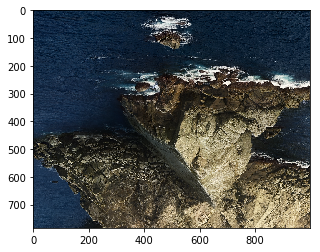

In [ ]:
upside_down = image[::-1]
plt.imshow(upside_down)
plt.show()

Let's rotate it! Note that we took this from another programmer (and referenced it to avoid plagiarism), and that there are other ways (namely with scikit-image) that take only 1 line of code to do the same thing.

Rotation matrix:
[[   0.76040597    0.64944805 -135.02621178]
 [  -0.64944805    0.76040597  417.9954376 ]]


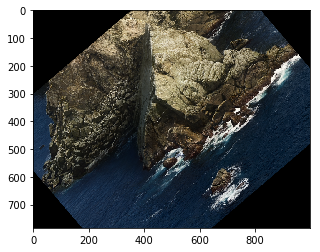

In [ ]:
# https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
# Copied from https://stackoverflow.com/a/9042907
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  print('Rotation matrix:')
  print(rot_mat)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

rotated = rotate_image(image, 40.5)
plt.imshow(rotated)
plt.show()

# Blurring

Now let's do a bit of linear filtering. First let's define a gaussian kernel function:

In [ ]:
# A large sigma is used, since we want to blur more.
std = 10
krad = int(3 * std)
ksize = 2 * krad + 1
kernel = np.zeros((ksize, ksize))
for i in range(ksize):
    for j in range(ksize):
        k = i - krad
        l = j - krad
        kernel[i][j] = 1.0 / (2 * np.pi * std ** 2) * np.exp(-(k ** 2 + l ** 2) / (2.0 * std ** 2))

Note that gaussian filter should approximately sum to 1, and that the choice of filter radius being 3 times the sigma can sufficiently capture the distribution:

In [ ]:
print(np.shape(kernel))
print(np.sum(kernel))

(61, 61)
0.995447696073


Now let's use opencv's filtering function to blur things:

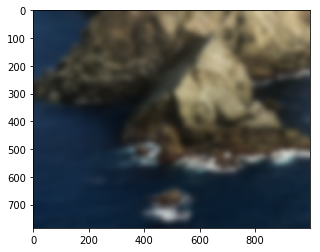

In [ ]:
blurred = cv2.filter2D(image, -1, kernel)
plt.imshow(blurred)
plt.show()

Well actually since it is a common filter, it could have been even easier. Note that the opencv implementation returns a _separable_ representation of the gaussian kernel -- it is more efficient than we were.

In [ ]:
kernel = cv2.getGaussianKernel(ksize, std)
print(np.shape(kernel))
print(np.sum(kernel))

(61, 1)
1.0


And still, it can get even easier! Here we perform everything in 1 line of code. If it might be commonly used, it is efficient to spend a few seconds googling for what you need first.

<function matplotlib.pyplot.show>

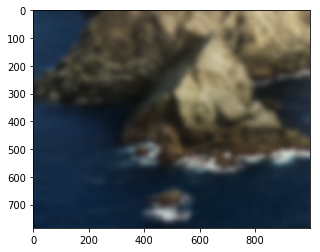

In [ ]:
# Last arg is sigma -- 0 is a special value to let opencv figure out an appropriate sigma for the ksize.
blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)
plt.imshow(blurred)
plt.show

Just for fun, let's see what we lost by blurring:

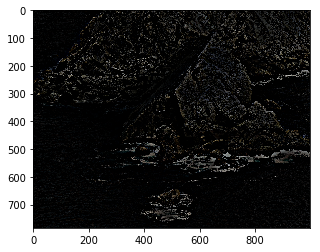

In [ ]:
diff = image - blurred
plt.imshow(diff)
plt.show()

# Image Gradients

This will show another application of linear filtering. To compute image gradients in one direction, we can use a central finite difference:

$\dfrac{\partial I(x)}{\partial x} \approx \dfrac{I(x + 1) - I(x - 1)}{2}$

Let's look at a bridge this time:

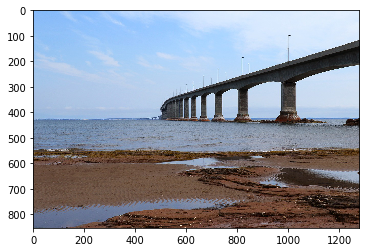

In [ ]:
image = read_image('bridge.jpg')
plt.imshow(image)
plt.show()

Since we care mostly about _how much_ change there is rather than whether it's positive or negative, we visualize the absolute values. Note that this filter captures large changes in the x-direction:

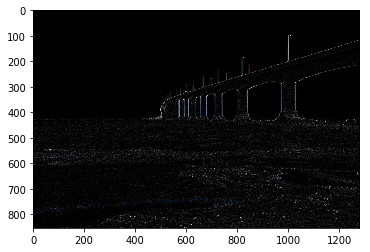

In [ ]:
gradx_kernel = np.array([[-1, 0, 1]]) / 2.0
gradx_abs = np.abs(cv2.filter2D(image, -1, gradx_kernel))
gradx_abs /= np.max(gradx_abs)
plt.imshow(gradx_abs)
plt.show()

Let's see what the y-direction derivative looks like:

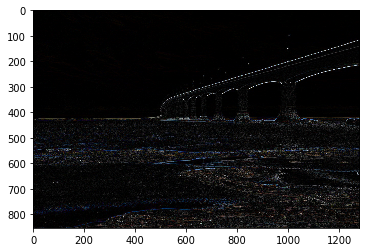

In [ ]:
# Note that we can simply transpose the x one!
grady_kernel = gradx_kernel.transpose()
grad_y = cv2.filter2D(image, -1, grady_kernel)

grady_abs = np.abs(cv2.filter2D(image, -1, grady_kernel))
grady_abs /= np.max(grady_abs)
plt.imshow(grady_abs)
plt.show()

# Scikit-Image

The CV toolbox that's available is extremely diverse. Especially when it comes to classical algorithms, you can do a lot with very few lines of code. Recall that looping in python is extremely slow, so try to use these (usually) optimized packages!

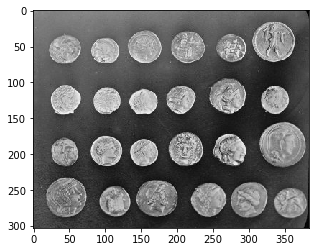

In [ ]:
# Adapted from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_template.html
from skimage import data
from skimage.feature import match_template

image = data.coins()
plt.imshow(image, cmap='gray')
plt.show()

Let's try to match the third row, second column coin:

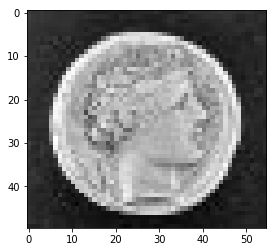

In [ ]:
coin_height = 50
coin_width = 55
coin = image[170:170 + coin_height, 75:75 + coin_width]
plt.imshow(coin, cmap='gray')
plt.show()

And find it by using normalized cross-correlation of the template with the image!

In [ ]:
result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
print('Best match for template at (y, x):', ij)

('Best match for template at (y, x):', (170, 75))


Now just plot the results:

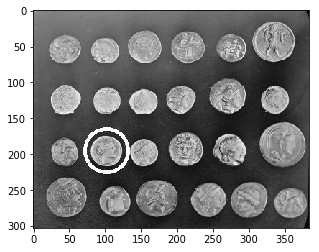

In [ ]:
y, x = ij
center_x = x + int(coin_width / 2)
center_y = y + int(coin_height / 2)
cv2.circle(image, (center_x, center_y), 30, (255, 255, 0), thickness=3)

plt.imshow(image, cmap='gray')
plt.show()